In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

#### Paquete de tiempo
import datetime

%matplotlib inline

In [2]:
### Cargar datos en Dataframes

Na_spectrum = pd.read_csv('INPUT/SODIO22.xls','Sheet 1', delimiter =' ', header = None, 
                 skiprows = 16, names =['del','Channel','Energy','Counts'],
                 usecols = ['Channel','Counts'])

Mn_spectrum = pd.read_csv('INPUT/MAGNESIO54.xls','Sheet 1', delimiter =' ', header = None, 
                 skiprows = 16, names =['del','Channel','Energy','Counts'],
                 usecols = ['Channel','Counts'])

Co57_spectrum = pd.read_csv('INPUT/COBALTO57.xls','Sheet 1', delimiter =' ', header = None, 
                 skiprows = 16, names =['del','Channel','Energy','Counts'],
                 usecols = ['Channel','Counts'])

Co60_spectrum = pd.read_csv('INPUT/COBALTO60.xls','Sheet 1', delimiter =' ', header = None, 
                 skiprows = 16, names =['del','Channel','Energy','Counts'],
                 usecols = ['Channel','Counts'])

Cd_spectrum = pd.read_csv('INPUT/CADMIO109.xls','Sheet 1', delimiter =' ', header = None, 
                 skiprows = 16, names =['del','Channel','Energy','Counts'],
                 usecols = ['Channel','Counts'])

Ba_spectrum = pd.read_csv('INPUT/BARIO133.xls','Sheet 1', delimiter =' ', header = None, 
                 skiprows = 16, names =['del','Channel','Energy','Counts'],
                 usecols = ['Channel','Counts'])

Cs_spectrum = pd.read_csv('INPUT/CESIO137.xls','Sheet 1', delimiter =' ', header = None, 
                 skiprows = 16, names =['del','Channel','Energy','Counts'],
                 usecols = ['Channel','Counts'])

Eu_spectrum = pd.read_csv('INPUT/EUROPIO152.xls','Sheet 1', delimiter =' ', header = None, 
                 skiprows = 16, names =['del','Channel','Energy','Counts'],
                 usecols = ['Channel','Counts'])

Fondo = pd.read_csv('INPUT/FONDO.xls','Sheet 1', delimiter =' ', header = None, 
                 skiprows = 16, names =['del','Channel','Energy','Counts'],
                 usecols = ['Channel','Counts'])



In [3]:
### Concatenar todos los espectros
df = pd.concat([Na_spectrum, Mn_spectrum, Co57_spectrum, Co60_spectrum, Cd_spectrum,
                Ba_spectrum, Cs_spectrum, Eu_spectrum, Fondo], ignore_index=True)
se = pd.Series(['Na22']*1024+['Mn54']*1024+['Co57']*1024+['Co60']*1024+['Cd109']*1024
               +['Ba133']*1024+['Cs137']*1024+['Eu152']*1024+['Fondo']*1024)
df['RN'] = se.values
#df

In [4]:
##### Cuentas totales en el espectro por nucleido
test=df.groupby(['RN'],as_index=False).sum()

#test[['RN','Counts']]
gross = pd.read_csv('crudos.csv', parse_dates=['Date_Ref'])
### Actividad de referencia en kBq
### Half life en días
#gross

#### Merge Dataframes
dt = pd.merge(gross,test[['RN','Counts']], on='RN')

In [5]:
#gross

,RN,Actividad_Ref,Date_Ref,Live_Time,Real_Time,Half_life
0,Na22,38.26,2011-03-01,1000.00,1008.74,950.57
1,Mn54,37.26,2011-03-01,1000.00,1000.67,312.29
2,Co57,37.04,2011-03-01,1000.00,1000.09,271.80
3,Co60,38.74,2011-03-01,1000.00,1019.71,1925.23
4,Cd109,37.07,2011-03-01,1000.00,1000.68,461.40
5,Ba133,37.04,2011-03-01,1000.00,1061.05,3848.70
6,Cs137,38.37,2011-03-01,1000.00,1038.52,10990.00
7,Eu152,18.50,2007-03-01,1000.00,1025.62,4941.00
8,Fondo,NaN,NaT,999.95,1000.00,NaN


In [6]:
##### Día de medición de fuentes tipo barra 
dM='31/10/2019'
dMbarra= datetime.datetime.strptime(dM,'%d/%m/%Y')

In [7]:
#### Tiempo transcurrido en días 
timeE=(dMbarra- gross['Date_Ref'])
#timeE
dt['timeE']= timeE.dt.days.values
#dt['Half_life']
#dt['timeE']

In [15]:
### Lambda
Lambda = np.log(2)/dt['Half_life']
### Actividad día de medición en Bequerelios (dps)
Actividad_dps = (dt['Actividad_Ref']*np.exp(-Lambda*dt["timeE"]))*1000
### Actividad día de medición en (dpm)
Actividad_dpm = (dt['Actividad_Ref']*np.exp(-Lambda*dt["timeE"]))*1000*60
Actividad_dps

0     3802.983737
1       33.067162
2       11.539635
3    12391.450828
4      318.740672
5    20943.008024
6    31424.693908
7     9666.564552
8             NaN
dtype: float64

In [11]:
#### Cuentas en el espectro de Fondo
cuentas_fondo = np.round((dt[dt['RN'] == 'Fondo']['Counts'] * 1000)/dt[dt['RN'] == 'Fondo']['Live_Time'],0)
#### Tasa de cuentas en el espectro de Fondo
tasa_fondo = dt[dt['RN'] == 'Fondo']['Counts']/(dt[dt['RN'] == 'Fondo']['Live_Time']/60)
#### Tasa de cuentas netas en el espectro de Fondo
tasa_fondoN = (dt[dt['RN'] == 'Fondo']['Counts']/(dt[dt['RN'] == 'Fondo']['Live_Time']/60))/(dt[dt['RN'] == 'Fondo']['Live_Time']/60)

In [12]:
#cuentas_fondo.values
#tasa_fondo.values
tasa_fondoN.values

array([ 58.01980184])

### Aplicando Poisson a datos 

* Número de cuentas : N

* Sigma de cuentas 
 $$\sigma_C = \sqrt N$$

* Cuentas netas: 

    $$N_g \text{:Gross counts}$$
    $$N_b \text{:Background counts}$$
    $$t_g \text{:Gross time}$$
    $$t_b \text{:Background time}$$
    
 $$N_s = N_g -\frac{N_b}{t_b}\cdot t_g$$

* Sigma de cuentas netas: 


 $$\sigma_s = \sqrt{N_g +\frac{N_b}{t_b}\cdot t_g}$$

* Tasa de Cuentas: t en minutos 

$$ R = \frac{N}{t}$$

* Sigma Tasa

$$ \sigma_R = \sqrt{\frac{R}{t}}$$

* Tasa Neta: t en minutos 

$$ R_s = R_g-R_b$$

* Sigma Tasa Neta

$$ \sigma_{R_s} = \sqrt{\frac{R_g}{t_g}+\frac{R_b}{t_b}}$$

In [13]:
#### Sigma de Cuentas
dt['Sigma_C']= np.sqrt(dt['Counts'])

#### Dead Time %
dt['Dead_Time_por'] = ((dt['Real_Time']-dt['Live_Time'])/dt['Real_Time'])*100

#### Dead Time [s]
dt['Dead_Time'] = dt['Real_Time']-dt['Live_Time']


#### Cuentas netas
dt['Cuentas_netas'] = dt['Counts']-cuentas_fondo.values

#### Sigma de Cuentas netas
dt['Sigma_CN'] = np.sqrt((dt['Counts']+ cuentas_fondo.values))

#### Tasa de cuentas en cpm
dt['Tasa'] = dt['Counts']/(dt['Live_Time']/60)

#### Sigma Tasa 
dt['Sigma_Tasa'] = np.sqrt(dt['Tasa']/(dt['Live_Time']/60))

#### Tasa netas
dt['Tasa_netas'] = dt['Tasa']-tasa_fondo.values

#### Sigma Tasa netas
dt['Sigma_TasaN'] = np.sqrt((dt['Tasa']/(dt['Live_Time']/60))+ tasa_fondoN.values)

In [14]:
dt

,RN,Actividad_Ref,Date_Ref,Live_Time,Real_Time,Half_life,Counts,timeE,Sigma_C,Dead_Time_por,Dead_Time,Cuentas_netas,Sigma_CN,Tasa,Sigma_Tasa,Tasa_netas,Sigma_TasaN
0,Na22,38.26,2011-03-01,1000.00,1008.74,950.57,2864059,3166.0,1692.353096,0.866427,8.74,2847943.0,1697.107834,1.718435e+05,101.541186,1.708766e+05,101.826481
1,Mn54,37.26,2011-03-01,1000.00,1000.67,312.29,223711,3166.0,472.980972,0.066955,0.67,207595.0,489.721349,1.342266e+04,28.378858,1.245571e+04,29.383318
2,Co57,37.04,2011-03-01,1000.00,1000.09,271.80,31084,3166.0,176.306551,0.008999,0.09,14968.0,217.255610,1.865040e+03,10.578393,8.980917e+02,13.035421
3,Co60,38.74,2011-03-01,1000.00,1019.71,1925.23,6346332,3166.0,2519.192728,1.932902,19.71,6330216.0,2522.389343,3.807799e+05,151.151564,3.798130e+05,151.343368
4,Cd109,37.07,2011-03-01,1000.00,1000.68,461.40,227003,3166.0,476.448318,0.067954,0.68,210887.0,493.070989,1.362018e+04,28.586899,1.265323e+04,29.584297
5,Ba133,37.04,2011-03-01,1000.00,1061.05,3848.70,20045630,3166.0,4477.234638,5.753735,61.05,20029514.0,4479.034048,1.202738e+06,268.634078,1.201771e+06,268.742047
6,Cs137,38.37,2011-03-01,1000.00,1038.52,10990.00,12697536,3166.0,3563.360212,3.709125,38.52,12681420.0,3565.620844,7.618522e+05,213.801613,7.608852e+05,213.937256
7,Eu152,18.50,2007-03-01,1000.00,1025.62,4941.00,8447320,4627.0,2906.427360,2.498001,25.62,8431204.0,2909.198515,5.068392e+05,174.385642,5.058723e+05,174.551917
8,Fondo,NaN,NaT,999.95,1000.00,NaN,16115,NaN,126.944870,0.005000,0.05,-1.0,179.529942,9.669483e+02,7.617073,0.000000e+00,10.772168


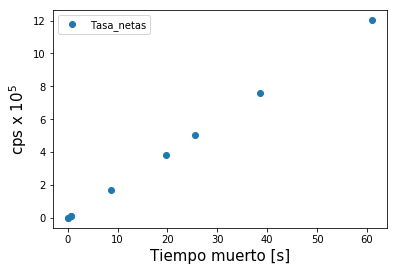

In [13]:
plt.plot(dt['Dead_Time'],dt['Tasa_netas']/100000,'o')

#plt.errorbar(dt['Dead_Time'],dt['Tasa_netas'], yerr=dt['Sigma_TasaN'],fmt='.b',label='datos',capsize=5)
#plt.plot(data['x'],(a+(b*data['x'])),'--r',label='Teoría')
plt.xlabel(r'Tiempo muerto [s]',size=15)
plt.ylabel(r'cps x 10$^5$',size=15)
plt.legend()

In [18]:
#plt.plot(Actividad_dps,dt['Dead_Time_por'],'o')

#plt.xlabel(r'Actividad [dps]',size=15)
#plt.ylabel(r'% Tiempo muerto',size=15)
#plt.legend()

(0, 700)

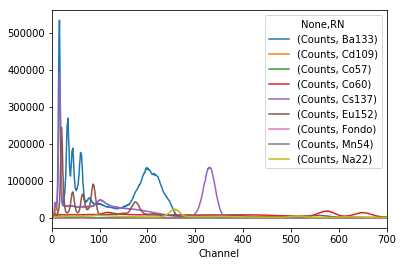

In [13]:
table = df.pivot(index ='Channel',columns ='RN')
#table.columns
#table
table.plot()
plt.xlim([0,700])

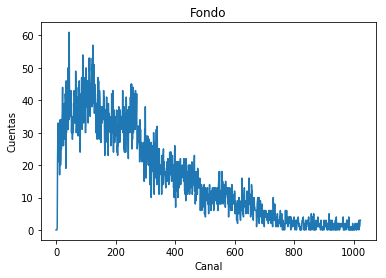

In [14]:
#### Graficar Espectro y fondo 
Canal = table.index
Fondo = table['Counts']['Fondo']

#### Fuente tipo barra
#Fuente = table['Counts']['Na22']

plt.title('Fondo')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.plot(Canal,Fondo)
#plt.plot(Canal,Fuente)

#plt.savefig('Fondo_source_bar.pdf')

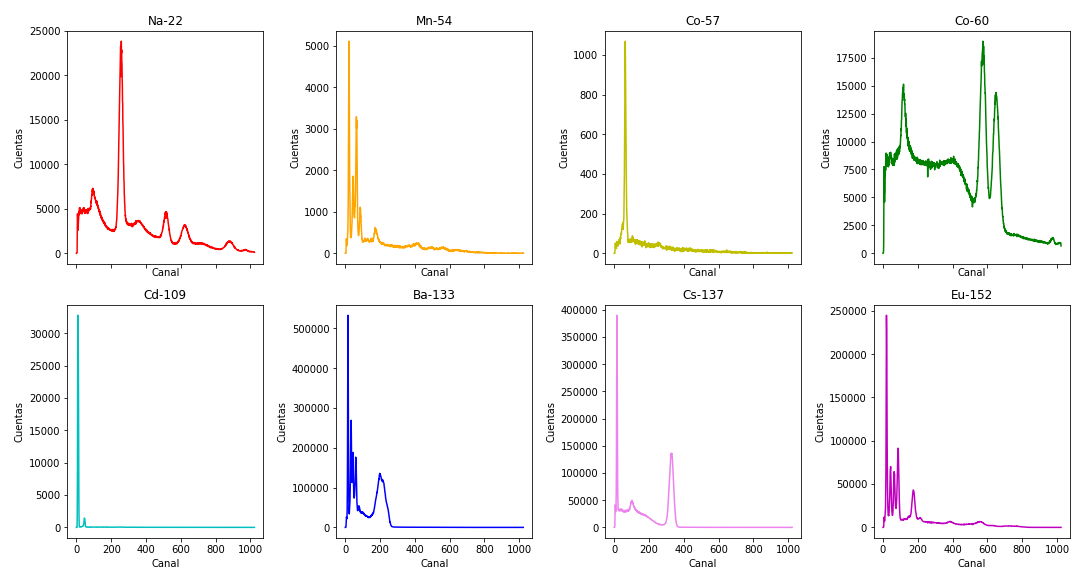

In [18]:
fig, axs = plt.subplots(2, 4, sharex='col',figsize=(15,8), constrained_layout=True)

#plt.figure(figsize=(12,8))

axs[0, 0].plot(Canal, table['Counts']['Na22'],'r')
axs[0, 0].set_title("Na-22")
axs[0, 1].plot(Canal,table['Counts']['Mn54'],'orange')
axs[0, 1].set_title("Mn-54")
#axs[1, 0].sharex(axs[0, 0])
axs[0, 2].plot(Canal, table['Counts']['Co57'],'y')
axs[0, 2].set_title("Co-57")
axs[0, 3].plot(Canal, table['Counts']['Co60'],'g')
axs[0, 3].set_title("Co-60")
axs[1, 0].plot(Canal, table['Counts']['Cd109'],'c')
axs[1, 0].set_title("Cd-109")
axs[1, 1].plot(Canal, table['Counts']['Ba133'],'b')
axs[1, 1].set_title("Ba-133")
axs[1, 2].plot(Canal, table['Counts']['Cs137'],'violet')
axs[1, 2].set_title("Cs-137")
axs[1, 3].plot(Canal, table['Counts']['Eu152'],'m')
axs[1, 3].set_title("Eu-152")


for ax in axs.flat:
    #ax.set_xlim([0, 950])
    ax.set(xlabel='Canal', ylabel='Cuentas')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
    #ax.label_outer()

fig.tight_layout()
#fig.savefig('Source_bar.pdf')

### Método A. Sustracción de espectro de fondo del espectro de la muestra

In [203]:
table[('Counts','Na22b')] =(table[('Counts', 'Na22')]-np.round(((table[('Counts', 'Fondo')]/999.95)*1000),0))
table[('Counts','Co57b')] =(table[('Counts', 'Co57')]-np.round(((table[('Counts', 'Fondo')]/999.95)*1000),0))
table[('Counts','Mn54b')] =(table[('Counts', 'Mn54')]-np.round(((table[('Counts', 'Fondo')]/999.95)*1000),0))
table[('Counts','Co60b')] =(table[('Counts', 'Co60')]-np.round(((table[('Counts', 'Fondo')]/999.95)*1000),0))
table[('Counts','Cd109b')] =(table[('Counts', 'Cd109')]-np.round(((table[('Counts', 'Fondo')]/999.95)*1000),0))
table[('Counts','Ba133b')] =(table[('Counts', 'Ba133')]-np.round(((table[('Counts', 'Fondo')]/999.95)*1000),0))
table[('Counts','Cs137b')] =(table[('Counts', 'Cs137')]-np.round(((table[('Counts', 'Fondo')]/999.95)*1000),0))
table[('Counts','Eu152b')] =(table[('Counts', 'Eu152')]-np.round(((table[('Counts', 'Fondo')]/999.95)*1000),0))

In [211]:
#table